# Terry Stop Legal Analysis and Prediction

## Project Overview

The goal of this project is to build a machine learning model that predicts whether an arrest was made following a Terry Stop. Using features such as the presence of weapons, the time of day, and other contextual factors recorded during the stop, the model classifies each case as either resulting in an arrest or not.
This is a binary classification problem.

## 1. Business Understanding

By analyzing this data, the project aims to:
- Understand whether gender, age, and reason for the stop influence the likelihood of an arrest.
- Develop a model that balances accuracy with justice.
- Explore patterns or potential biases in Terry Stops.
- Understand the bias in Arrests made. 


## 2. Data Understanding
Source of data : This data is from the Seattle Police Department. This data represents records of police reported stops under Terry v. Ohio, 392 U.S. 1 (1968). Each row represents a unique stop.

In [1]:
#Importing the needed Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt #For visualisations
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression #First model
from sklearn.tree import DecisionTreeClassifier #Second model

In [2]:
#Load the data
df = pd.read_csv("Terry_Stops_20250507.csv")

In [3]:
#Look at the dataset
df.head(5)

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,26 - 35,9770358745,20190000313099,9770376049,Field Contact,-,5653,1967,M,Black or African American,...,00:25:27.0000000,SHOPLIFT - THEFT,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,SOUTH PCT 2ND W - ROBERT - PLATOON 2,N,N,-,-,-
1,26 - 35,-1,20160000282794,180985,Arrest,Handgun,6355,1970,F,White,...,07:09:00.0000000,DISTURBANCE,NARCOTICS - OTHER,911,EAST PCT 1ST W - E/G RELIEF (CHARLIE),N,N,East,C,C3
2,26 - 35,-1,20180000002480,438562,Field Contact,NaN,7564,1979,M,Declined to Answer,...,13:50:00.0000000,-,-,-,WEST PCT 2ND W - DAVID BEATS,N,N,-,-,-
3,36 - 45,-1,20180000065356,392012,Offense Report,NaN,7514,1987,M,White,...,02:09:00.0000000,ROBBERY - CRITICAL (INCLUDES STRONG ARM),ROBBERY - ARMED,911,NORTH PCT 3RD W - BOY (JOHN) - PLATOON 1,N,N,North,L,L2
4,56 and Above,-1,20170000004325,309626,Field Contact,NaN,6783,1976,M,White,...,15:00:00.0000000,-,-,-,EAST PCT 2ND W - GEORGE - PLATOON 2,N,N,-,-,-


In [4]:
#Number of rows and columns
df.shape

(63462, 23)

In [5]:
#Overview of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63462 entries, 0 to 63461
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         63462 non-null  object
 1   Subject ID                63462 non-null  int64 
 2   GO / SC Num               63462 non-null  int64 
 3   Terry Stop ID             63462 non-null  int64 
 4   Stop Resolution           63462 non-null  object
 5   Weapon Type               30897 non-null  object
 6   Officer ID                63462 non-null  object
 7   Officer YOB               63462 non-null  int64 
 8   Officer Gender            63462 non-null  object
 9   Officer Race              63462 non-null  object
 10  Subject Perceived Race    63462 non-null  object
 11  Subject Perceived Gender  63462 non-null  object
 12  Reported Date             63462 non-null  object
 13  Reported Time             63462 non-null  object
 14  Initial Call Type     

Description and Size of data: The dataset contains 5,000 records with 8 categorical features, such as 'Arrest Made' (Yes/No). Most data types are objects, with only one date at  Officer YOB and three other IDs.

## 3. Data Preparation
The data preparation has 2 parts cleaning and preprocessing for modeling.

### Data cleaning
First, I will check for Nulls, duplicate rows and change the Officer YOB type in
to a date and the ID columns into strings to help with filtering and parsing.

In [6]:
#Finding Nulls
df.isna().sum()

Subject Age Group               0
Subject ID                      0
GO / SC Num                     0
Terry Stop ID                   0
Stop Resolution                 0
Weapon Type                 32565
Officer ID                      0
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race          0
Subject Perceived Gender        0
Reported Date                   0
Reported Time                   0
Initial Call Type               0
Final Call Type                 0
Call Type                       0
Officer Squad                 561
Arrest Flag                     0
Frisk Flag                      0
Precinct                        0
Sector                          0
Beat                            0
dtype: int64

In [7]:
#Fill in the nulls with N/A
df['Weapon Type'].fillna('NaN', inplace=True)
df['Officer Squad'].fillna('NaN', inplace=True)

In [8]:
#Looking for duplicate rows
df.duplicated().value_counts()

False    63462
Name: count, dtype: int64

There are no duplicate rows

In [9]:
#Convert data types for easy analysis
df['Officer YOB'] = pd.to_datetime(df['Officer YOB'], format='%Y')
df['Reported Date'] = pd.to_datetime(df['Reported Date'])
df[['Subject ID', 'GO / SC Num' ,'Terry Stop ID']] = df[['Subject ID', 'GO / SC Num' ,'Terry Stop ID']].astype(str)

In [10]:
#Overview of updated columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63462 entries, 0 to 63461
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Subject Age Group         63462 non-null  object             
 1   Subject ID                63462 non-null  object             
 2   GO / SC Num               63462 non-null  object             
 3   Terry Stop ID             63462 non-null  object             
 4   Stop Resolution           63462 non-null  object             
 5   Weapon Type               63462 non-null  object             
 6   Officer ID                63462 non-null  object             
 7   Officer YOB               63462 non-null  datetime64[ns]     
 8   Officer Gender            63462 non-null  object             
 9   Officer Race              63462 non-null  object             
 10  Subject Perceived Race    63462 non-null  object             
 11  Subject Perceiv

In [11]:
#Clean the categories eg remove spaces and standardize 
df['Subject Age Group'] = df['Subject Age Group'].str.strip()
df['Subject Age Group'] = df['Subject Age Group'].str.replace(' - ', '-', regex=False)

### Detailed Overview of the data

I will have a further analysis of specific columns those that will later on be used as selected features, including the age group, and then a look at the trend of reports over time.

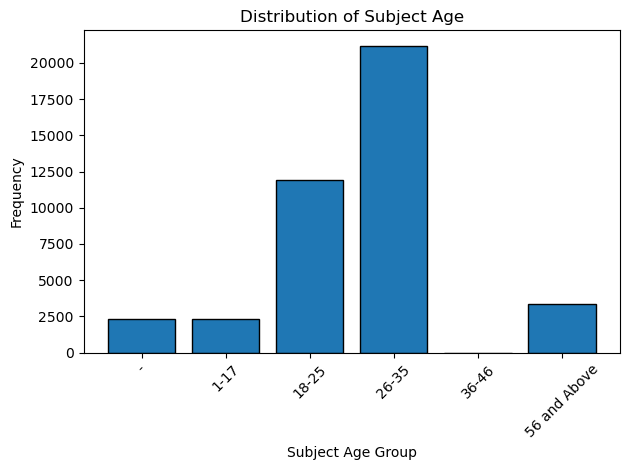

In [12]:
# Distribution of Subject Age (using bar instead, because I want to order the columns)
order = ['-', '1-17', '18-25', '26-35', '36-46', '56 and Above']

# Count the frequencies in your DataFrame
age_counts = df['Subject Age Group'].value_counts().reindex(order, fill_value=0)

plt.bar(age_counts.index, age_counts.values, edgecolor='black')
plt.title('Distribution of Subject Age')
plt.xlabel('Subject Age Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
'''
Highest number of terry stops happen to suspects around the age of 26 - 35.
'''

'\nHighest number of terry stops happen to suspects around the age of 26 - 35.\n'

In [14]:
#Overview of the Gender column values
gender_counts = df['Subject Perceived Gender'].value_counts()
gender_counts

Subject Perceived Gender
Male                                                         50112
Female                                                       12599
Unable to Determine                                            326
-                                                              248
Unknown                                                        113
Gender Diverse (gender non-conforming and/or transgender)       63
MULTIPLE SUBJECTS                                                1
Name: count, dtype: int64

In [15]:
#Simplifying and cleaning the gender column
df['Subject Perceived Gender'] = df['Subject Perceived Gender'].replace({'Gender Diverse (gender non-conforming and/or transgender)': 'Gender Diverse','-': 'Unknown','Unable to Determine': 'Unknown','MULTIPLE SUBJECTS': 'Unknown',
})

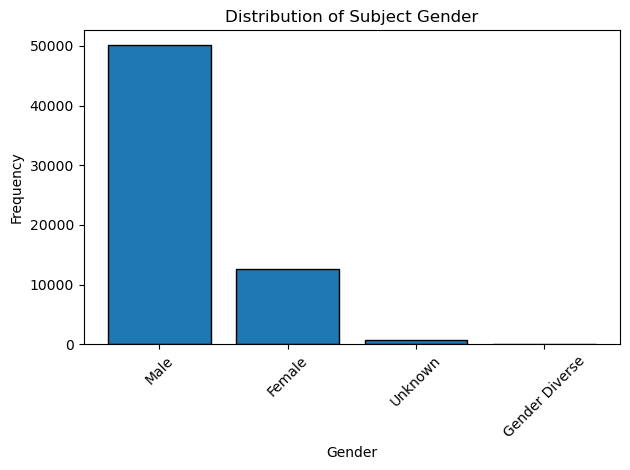

In [16]:
#Gender Distribution
gender_counts = df['Subject Perceived Gender'].value_counts()

plt.bar(gender_counts.index, gender_counts.values, edgecolor='black')
plt.title('Distribution of Subject Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
'''
The highest number of Terry stops is with the male gender. This could be due to either male bias concerning the police or
a higher involvement of males in activities that draws police attention. 

'''

'\nThe highest number of Terry stops is with the male gender. This could be due to either male bias concerning the police or\na higher involvement of males in activities that draws police attention. \n\n'

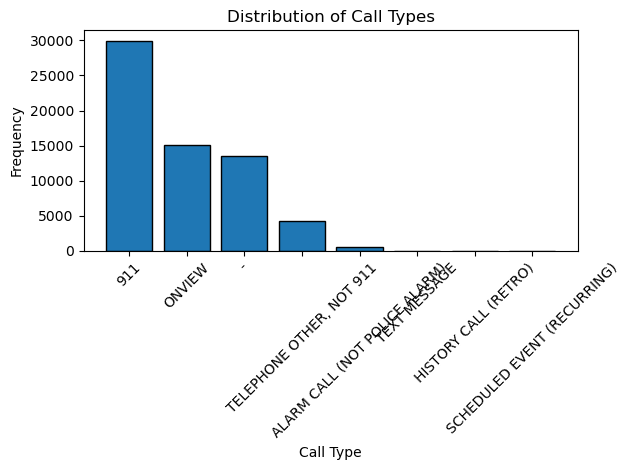

In [18]:
#Call Stops Distribution
call_counts = df['Call Type'].value_counts()

plt.bar(call_counts.index, call_counts.values, edgecolor='black')
plt.title('Distribution of Call Types')
plt.xlabel('Call Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
'''
The number of terry stops often start with a 911 call or secondly onview
which means police officers just observe.
'''

'\nThe number of terry stops often start with a 911 call or secondly onview\nwhich means police officers just observe.\n'

C:\Users\MichelleChekwooti\AppData\Local\Temp\ipykernel_10612\2507407185.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_trend = df['Reported Date'].dt.to_period('M').value_counts().sort_index()


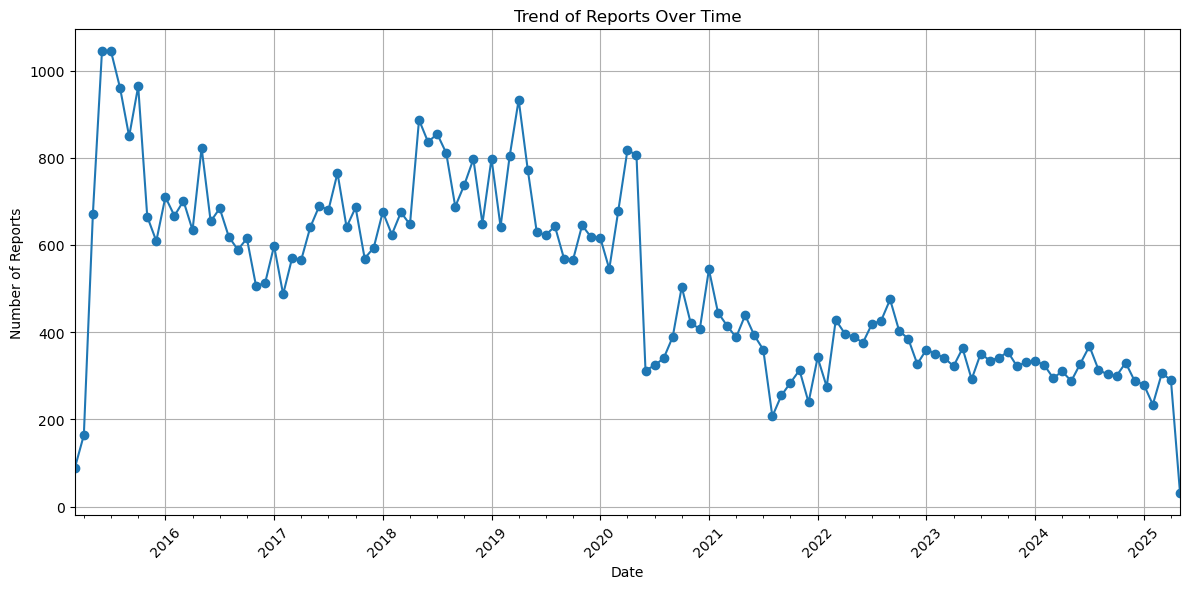

In [20]:
# trend of reports over time
df_trend = df['Reported Date'].dt.to_period('M').value_counts().sort_index()

df_trend.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Trend of Reports Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reports')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
'''
The number of terry stops has decreased over the years this could be due to changes 
in police policies or the influence of public opinion.
'''

'\nThe number of terry stops has decreased over the years this could be due to changes \nin police policies or the influence of public opinion.\n'

### Preprocessing
I will now choose the X and Y and prepare them , this also includes looking for issues,one hot encoding and imbalance in the dataset.

In [22]:
#Convert the string values in the Y also.
df['Arrest Flag'] = df['Arrest Flag'].map({'N': 0, 'Y': 1})

In [23]:
# Define X and y
X = df[['Subject Age Group', 'Call Type', 'Subject Perceived Gender']]
y = df['Arrest Flag']

In [24]:
# One hot encoding to convert the categories
ohe = OneHotEncoder(sparse=False)
data_coded = X.copy()
data_coded

,Subject Age Group,Call Type,Subject Perceived Gender
0,26-35,ONVIEW,Male
1,26-35,911,Male
2,26-35,-,Male
3,36-45,911,Female
4,56 and Above,-,Male
...,...,...,...
63457,36-45,ONVIEW,Female
63458,1-17,ONVIEW,Female
63459,26-35,"TELEPHONE OTHER, NOT 911",Male
63460,-,ONVIEW,Female


In [25]:
#Fit the encoded data
X_encoded = ohe.fit_transform(data_coded)

C:\Users\MichelleChekwooti\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [26]:
#Find the column names and create a dataframe for the encoded figures
column_names = ohe.get_feature_names_out(data_coded.columns)

X_data = pd.DataFrame(X_encoded, columns=column_names)
X_data

,Subject Age Group_-,Subject Age Group_1-17,Subject Age Group_18-25,Subject Age Group_26-35,Subject Age Group_36-45,Subject Age Group_46-55,Subject Age Group_56 and Above,Call Type_-,Call Type_911,Call Type_ALARM CALL (NOT POLICE ALARM),Call Type_HISTORY CALL (RETRO),Call Type_ONVIEW,Call Type_SCHEDULED EVENT (RECURRING),"Call Type_TELEPHONE OTHER, NOT 911",Call Type_TEXT MESSAGE,Subject Perceived Gender_Female,Subject Perceived Gender_Gender Diverse,Subject Perceived Gender_Male,Subject Perceived Gender_Unknown
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63457,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
63458,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
63459,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
63460,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## 4. Modeling and Evaluation

I will be using Logistic Regresstion and Decision tress.

**Logistic Regresstion**

I used this model because it is used for binary classification problems, where the outcome has only two possible values such as whether an arrest was made 1 or not 0. The model takes features and estimates the probability of an arrest occurring. Based on this probability, it predicts the outcome as either 0 or 1 which will help understanding patterns in the Terry Stop data.

In [27]:
#Split the data into Train and Test
'''
I chose a test size of 80% for training and a random state of 42.
'''
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.2, random_state=42)

In [28]:
#Look for class imbalance in the target variable
print("Class distribution ")
print(y_train.value_counts(normalize=True))
print("Class distribution")
print(y_test.value_counts(normalize=True))

Class distribution 
Arrest Flag
0    0.888278
1    0.111722
Name: proportion, dtype: float64
Class distribution
Arrest Flag
0    0.889152
1    0.110848
Name: proportion, dtype: float64


There is a large imbalance in the dataset with the majority being Not Arrested , 0 and the model will have trouble predicting when they are arrested. I have to reduce this imbalance by adjusting the class weights and using SMOTE to improve performance.

In [29]:
from imblearn.over_sampling import SMOTE

print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

Arrest Flag
0    56383
1     7079
Name: count, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

Arrest Flag
0    45097
1    45097
Name: count, dtype: int64


In [30]:
#Fitting the model
logreg = LogisticRegression(class_weight='balanced', fit_intercept=True, C=1e12, solver='liblinear')
baseline_model = logreg.fit(X_train_resampled, y_train_resampled)
baseline_model

LogisticRegression(C=1000000000000.0, class_weight='balanced',
                   solver='liblinear')

In [31]:
#Predict
y_pred_test = logreg.predict(X_test)

Considering which feature is the most important can also help the analysis, understand what should have more weight. S,o finding the coefficients of the chosen features and valuing them is needed.

In [32]:
#Which feature has the most influence over the Terry stop?
# Find coefficients
coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': logreg.coef_[0]})

# Sort by value
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False)

coefficients.drop('Abs_Coefficient', axis=1, inplace=True)
print(coefficients)

                                    Feature  Coefficient
12    Call Type_SCHEDULED EVENT (RECURRING)    -2.299581
10           Call Type_HISTORY CALL (RETRO)    -2.233673
18         Subject Perceived Gender_Unknown    -2.077155
0                       Subject Age Group_-    -1.657891
14                   Call Type_TEXT MESSAGE     1.396341
7                               Call Type_-    -1.282722
9   Call Type_ALARM CALL (NOT POLICE ALARM)     1.097635
8                             Call Type_911     1.053821
16  Subject Perceived Gender_Gender Diverse     0.786776
13       Call Type_TELEPHONE OTHER, NOT 911     0.707741
1                    Subject Age Group_1-17    -0.515756
11                         Call Type_ONVIEW     0.513188
4                   Subject Age Group_36-45     0.375327
3                   Subject Age Group_26-35     0.304407
17            Subject Perceived Gender_Male     0.259841
6            Subject Age Group_56 and Above     0.214630
5                   Subject Age

In [33]:
'''
This shows the feature with the most influence to being arrested has a positive Call Type 911 of 1.06,
the least shows a negative call type of -2.32 with a scheduled event.
It also shows how the perceived gender of a male and those that are mixed gender is positive and more likely to get arrested,
while that of a female is negative and she will not be arrested.
The most likely age group to influence a Terry stop with an arrest is the 36-45,
Unlike that of the younger 1-17, which is negative.
'''

'\nThis shows the feature with the most influence to being arrested has a positive Call Type 911 of 1.06,\nthe least shows a negative call type of -2.32 with a scheduled event.\nIt also shows how the perceived gender of a male and those that are mixed gender is positive and more likely to get arrested,\nwhile that of a female is negative and she will not be arrested.\nThe most likely age group to influence a Terry stop with an arrest is the 36-45,\nUnlike that of the younger 1-17, which is negative.\n'

**Evaluation**

In [34]:
#Overview of the performance of the model
from sklearn.metrics import classification_report


report = classification_report(y_test, y_pred_test, target_names=['Not Arrested', 'Arrested'])
print(report)

              precision    recall  f1-score   support

Not Arrested       0.95      0.43      0.59     11286
    Arrested       0.15      0.83      0.26      1407

    accuracy                           0.48     12693
   macro avg       0.55      0.63      0.43     12693
weighted avg       0.86      0.48      0.56     12693



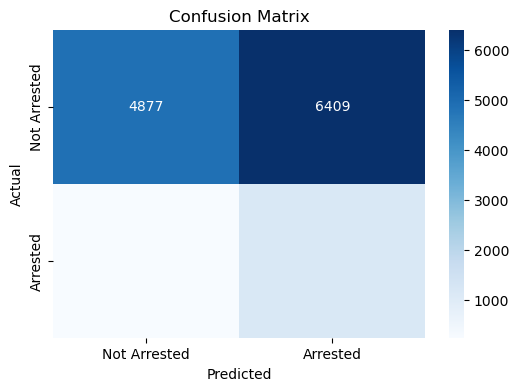

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# created a confusion matrix to overview the results
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Arrested', 'Arrested'], yticklabels=['Not Arrested', 'Arrested'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [36]:
'''
The performance metrics are quite low even after fixing imbalance,
The precision for Not arrested is 0.95, which shows it is very good at identifying
Not Arrested cases but has issus with Arrested.
The recall for arrested is high at 0.83 so it gets the arrested cases well.
However the overall Accuracy is low at 0.48, meaning only a few predictions actually match
the actual outcomes. This is likely do to overfitting of the majority class,
Not Arrested.
'''

'\nThe performance metrics are quite low even after fixing imbalance,\nThe precision for Not arrested is 0.95, which shows it is very good at identifying\nNot Arrested cases but has issus with Arrested.\nThe recall for arrested is high at 0.83 so it gets the arrested cases well.\nHowever the overall Accuracy is low at 0.48, meaning only a few predictions actually match\nthe actual outcomes. This is likely do to overfitting of the majority class,\nNot Arrested.\n'

**Decision Tree**

I am using a decision tree for my second model because it does not assume
a linear relationship and can handle complex patterns. It is also a classification model
and will help evaluate the performance of the baseline model. I can determine whether a more flexible,
non-linear model improves prediction accuracy 

In [37]:
#Decision Tree classifier
clf = DecisionTreeClassifier(criterion='entropy',class_weight='balanced')
#Fit the model
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy')

In [38]:
y_preds_test2 = clf.predict(X_test)


**Evaluate**

In [39]:
#Overview of the performance of the model
report = classification_report(y_test, y_preds_test2, target_names=['Not Arrested', 'Arrested'])
print(report)

              precision    recall  f1-score   support

Not Arrested       0.95      0.43      0.59     11286
    Arrested       0.15      0.83      0.26      1407

    accuracy                           0.48     12693
   macro avg       0.55      0.63      0.43     12693
weighted avg       0.86      0.48      0.56     12693



In [40]:
'''
The precision for Not arrested is 0.95, which shows it is also very good at identifying Not Arrested cases but has issue swith Arrested.
The recall for arrested is high at 0.83 so it gets the arrested cases well also.
However the overall Accuracy is also low at 0.48, meaning only a few predictions actually match the actual outcomes.
'''

'\nThe precision for Not arrested is 0.95, which shows it is also very good at identifying Not Arrested cases but has issue swith Arrested.\nThe recall for arrested is high at 0.83 so it gets the arrested cases well also.\nHowever the overall Accuracy is also low at 0.48, meaning only a few predictions actually match the actual outcomes.\n'

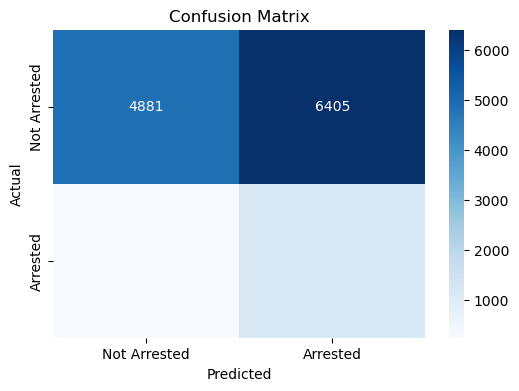

In [41]:
# Created a confusion matrix to look at the results
cm = confusion_matrix(y_test, y_preds_test2)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Arrested', 'Arrested'], yticklabels=['Not Arrested', 'Arrested'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 4. Recommendations

The model would be useful in:
- Reviewing and updating Policy: This could help police departments understand which types of stops most often lead to arrests and investigate patterns.

- To detect bias: To look at areas where Arrests are made and flag harmful patterns that can be later on discussed.

- In Training and Awareness: The data and model can be used to show officers or the community where certain factors may unintentionally influence bias; this will help in promoting more informed decision making.

- A threshold for the Logistic regression would need to be established to improve the performance of the data and have better precision and recall trade-offs.

## 5. Conclusions


- The data was highly imbalanced however, considering how this is based on arrests in the Chicago area and the nature of police work ,it is not considered abnormal to have a large number of Not Arrested in favour of Arrested.

- Given the context of predictive policing and civil rights, precision and recall for the Arrested are our most important metrics. Recall must be maximized to understand all potential arrests, but also to improve precision to avoid falsely predicting arrests, which could lead to bias.

- The final model chosen is the Logistic Regression model as it was better able to better handle the imbalance of the Terry stop data, decision trees have clear splits based on feature values, which is not as flexible in adjusting for imbalance.

- The evaluation metrics showed the model predicted "Not Arrested" cases well, with no false negatives and a high number of true negatives. However, it struggled to correctly identify actual arrests, resulting in a low number of true positives and a high number of false negatives. This means the model made both Type I errors (false positives) and Type II errors (false negatives), although Type II errors were more pronounced.

These findings highlight the difficulty of predicting arrests in an imbalanced dataset and suggest the need for further refinement, possibly through better feature selection, alternative models, or fairness-aware techniques.